### 데이터 가이드라인 기반 분석

json파일 정보 분석
- description(상단부)
    + image : 파일 이름
    + height, width : 너비, 높이
    + type : 촬영 유형 (0:정상, 1:질병, 2:해충, 3:충해)
- annotations(하단부)
    + disease : 질병/해충코드 (5: 검은썩은병, 6: 배추노균병, 0: 정상)
    + crop : 작물 코드
    + area : 촬영 부위
    + grow : 작물 생육단계
    + risk : 질병 피해 정도
    + points : bbox좌표값 (tl:top left, br:bottom right)

In [1]:
import os
import cv2
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Model, load_model
from tensorflow.python.client import device_lib
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet152, DenseNet121, ResNet50
from keras.callbacks import EarlyStopping, CSVLogger, ReduceLROnPlateau
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten


mlp.rcParams["font.family"] = "Malgun Gothic"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12431824980978163843
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10063183872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13246422971793910387
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [ ]:
class_dir = "./napa_cabbage/Data/labels/"
image_dir = "./napa_cabbage/Data/images/"
new_image_dir = "./napa_cabbage/classification/"

base_dir = './classification_dataset'  # 증강기에 들어가는 최종 이미지 path

model_path = "./model/weights/cabbage_classification.1.0.0.h5"  # 모델 weight 저장할 위치
history_path = "./model/history/cabbage_classification.1.0.0.csv"  # 학습 곡선 시각화를 위한 model training history

In [18]:
classes = {0:"normal", 5:"black_rot", 6:"syngenta"}

for class_ in os.listdir(class_dir):
    label_dir = os.path.join(class_dir, class_)
    for filename in os.listdir(label_dir):
        json_file_path = os.path.join(label_dir, filename)
        with open(json_file_path, "r", encoding="utf8") as file:
            json_file = json.load(file)
        
        image_filename = json_file["description"]["image"]  # 이미지 파일 이름 가져오기
        disease_num = json_file["annotations"]["disease"]  # 질병 번호 가져오기

        image_folder = os.path.join(image_dir, class_)  # 원본 이미지 dir + class (ex. ./napa_cabbage/Data/images/black_rot)
        image_path = os.path.join(image_folder, image_filename)  # 원본 이미지 full path (ex. ./napa_cabbage/Data/images/black_rot/V006_79_1_05_03_03_11_1_1299b_20201023_19_a0000.jpg)

        new_image_folder = os.path.join(new_image_dir, classes[disease_num])  # 이동할 경로 folder dir + class (ex. ./napa_cabbage/classification/black_rot)
        new_image_path = os.path.join(new_image_folder, image_filename)  # 이동할 경로 full path (ex. ./napa_cabbage/classification/black_rot/V006_79_1_05_03_03_11_1_1299b_20201023_19_a0000.jpg)

        shutil.move(image_path, new_image_path)
        
        file.close()

### Classification first
classification부터 수행한다.

In [27]:
IMAGE_DATA_ROOT = "./napa_cabbage/classification/"
CLASSES = os.listdir(IMAGE_DATA_ROOT)

class1 = os.path.join(IMAGE_DATA_ROOT, CLASSES[0])
class2 = os.path.join(IMAGE_DATA_ROOT, CLASSES[1])
class3 = os.path.join(IMAGE_DATA_ROOT, CLASSES[2])

black_rot = os.listdir(class1)
normal = os.listdir(class2)
syngenta = os.listdir(class3)

print(len(black_rot), len(normal), len(syngenta))

592 591 592


In [25]:
black_rot_move_dir = "./class_backup/black_rot/"
normal_move_dir = "./class_backup/normal/"

for filename in black_rot[:576]:
    shutil.move(os.path.join(class1, filename), os.path.join(black_rot_move_dir, filename))

for filename in normal[:592]:
    shutil.move(os.path.join(class2, filename), os.path.join(normal_move_dir, filename))

In [29]:
import splitfolders

splitfolders.ratio("./napa_cabbage/classification/", "./classification_dataset", seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 1775 files [00:17, 101.40 files/s]


In [2]:
# 증강 옵션 설정(For Train set)
train_datagen = ImageDataGenerator(
    rescale=1./255,  # 이미지 정규화
    shear_range=0.2,  # 0~45도 사이 값으로 X축 or Y축 중심 변환
    rotation_range=45,  # 회전 각도
    horizontal_flip=True,  # 수평 반전
    vertical_flip=True  # 수직반전
    )

# 증강 옵션 설정(For Validation Set) : Train Generator와 동일
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=45,
    horizontal_flip=True,
    vertical_flip=True
    )

# 증강 옵션 설정(For Test Set) : 테스트 시에는 별도의 옵션 없이 진행
test_datagen = ImageDataGenerator(
    rescale=1./255
    )

# 증강 옵션 적용부(Train, Valid, Test)
train_generator = train_datagen.flow_from_directory(
    f'{base_dir}/train',
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb"
    )

validation_generator = validation_datagen.flow_from_directory(
    f'{base_dir}/val',
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb"
    )

test_generator = test_datagen.flow_from_directory(
    f'{base_dir}/test',
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False
    )

Found 1241 images belonging to 3 classes.
Found 354 images belonging to 3 classes.
Found 180 images belonging to 3 classes.


In [36]:
params = {
    'input_shape' : (512, 512, 3), 
    'include_top': False,
    'weights':'imagenet',
    'classes': 3,
    "pooling" : "max"
}

# Densenet transfer learning
base_model = DenseNet121(**params)

# functional API method로 모델 구성
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 미세 조정 : 전 계층 동결
for layer in base_model.layers:
    layer.trainable = False

# callback 함수 정의
els = EarlyStopping(monitor="val_loss", patience=5, mode="min")
reduce = ReduceLROnPlateau(monitor="val_loss", patience=3, mode="min", factor=0.1)
csv_logger = CSVLogger(history_path)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 학습 후 저장
model.fit(train_generator, epochs=100, validation_data=validation_generator, callbacks=[els, reduce, csv_logger])
model.save(model_path)

Epoch 1/100
39/39 [==============================] - 206s 5s/step - loss: 1.8514 - accuracy: 0.6737 - val_loss: 0.3492 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 2/100
39/39 [==============================] - 196s 5s/step - loss: 0.1927 - accuracy: 0.9291 - val_loss: 0.0905 - val_accuracy: 0.9746 - lr: 0.0010
Epoch 3/100
39/39 [==============================] - 197s 5s/step - loss: 0.1501 - accuracy: 0.9428 - val_loss: 0.1936 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 4/100
39/39 [==============================] - 195s 5s/step - loss: 0.1149 - accuracy: 0.9597 - val_loss: 0.1104 - val_accuracy: 0.9661 - lr: 0.0010
Epoch 5/100
39/39 [==============================] - 193s 5s/step - loss: 0.0818 - accuracy: 0.9686 - val_loss: 0.0597 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 6/100
39/39 [==============================] - 193s 5s/step - loss: 0.1361 - accuracy: 0.9517 - val_loss: 0.0488 - val_accuracy: 0.9774 - lr: 0.0010
Epoch 7/100
39/39 [==============================] - 194s 5s/step - lo

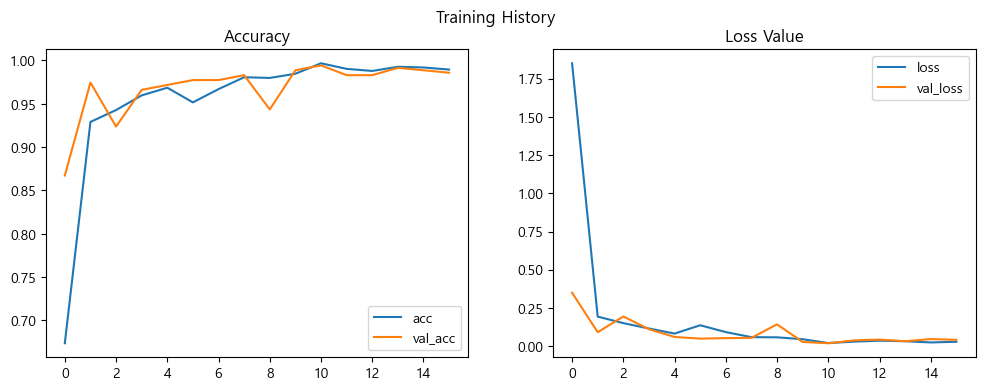

In [4]:
history = pd.read_csv(history_path)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["epoch"], history["accuracy"], label="acc")
plt.plot(history["epoch"], history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["epoch"], history["loss"], label="loss")
plt.plot(history["epoch"], history["val_loss"], label="val_loss")
plt.title("Loss Value")
plt.legend()

plt.suptitle("Training History")
plt.show()

In [8]:
model = load_model(model_path)
y_true = test_generator.classes
y_pred = []

for pred in model.predict(test_generator, verbose=0):
    y_pred.append(np.argmax(pred))

In [39]:
print(classification_report(y_pred=y_pred, y_true=y_true))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.92      1.00      0.96        60
           2       1.00      0.92      0.96        60

    accuracy                           0.97       180
   macro avg       0.97      0.97      0.97       180
weighted avg       0.97      0.97      0.97       180



In [ ]:
class_names = {0 : "검은썩음병", 1 : "정상", 2 : "배추노균병"}  # 각 클래스 별 이름
root = "./napa_cabbage/classification/"  # 이미지 root 
image_filenames = [i.replace("\\", "/") for i in test_generator.filenames]  # 클래스 명/파일이름 형식의 image filenames
row_col = round(np.sqrt(len(image_filenames)))  # 이미지 시각화에 사용

fig, axis = plt.subplots(nrows=row_col, ncols=row_col, figsize=(80, 80))
plt.subplots_adjust(left=0.125, bottom=0.4, right=0.9, top=0.9, wspace=0.2, hspace=0.6)
plt.tight_layout(h_pad=1.08)

for idx, pred in enumerate(model.predict(test_generator, verbose=0)):
    img_array, label = test_generator.next()
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_class_idx = test_generator.classes[idx]
    pred_class_idx = np.argmax(pred)
    
    true_class_name = class_names[true_class_idx]
    pred_class_name = class_names[pred_class_idx]

    axis[idx//row_col][idx%row_col].imshow(image)
    axis[idx//row_col][idx%row_col].set_xlabel(f"true : {true_class_name}")
    axis[idx//row_col][idx%row_col].set_title(f"pred : {pred_class_name}")

plt.show()

[[[[0.16862746 0.1254902  0.11764707]
   [0.09019608 0.09019608 0.08235294]
   [0.10588236 0.09019608 0.07843138]
   ...
   [0.5372549  0.62352943 0.05490196]
   [0.5294118  0.6        0.05882353]
   [0.5137255  0.5803922  0.0627451 ]]

  [[0.1137255  0.10980393 0.10196079]
   [0.10196079 0.08235294 0.06666667]
   [0.13725491 0.12156864 0.10980393]
   ...
   [0.54509807 0.6313726  0.05490196]
   [0.5058824  0.5921569  0.05490196]
   [0.49411768 0.5686275  0.06666667]]

  [[0.05882353 0.06666667 0.02352941]
   [0.10196079 0.09803922 0.07843138]
   [0.08235294 0.06666667 0.05490196]
   ...
   [0.54901963 0.63529414 0.06666667]
   [0.5176471  0.5921569  0.03921569]
   [0.5176471  0.58431375 0.06666667]]

  ...

  [[0.14509805 0.13725491 0.08627451]
   [0.19607845 0.2392157  0.10588236]
   [0.29803923 0.29411766 0.1764706 ]
   ...
   [0.5019608  0.42352945 0.22352943]
   [0.37647063 0.3372549  0.10588236]
   [0.5882353  0.49803925 0.22352943]]

  [[0.2627451  0.25882354 0.18039216]
   [0.2

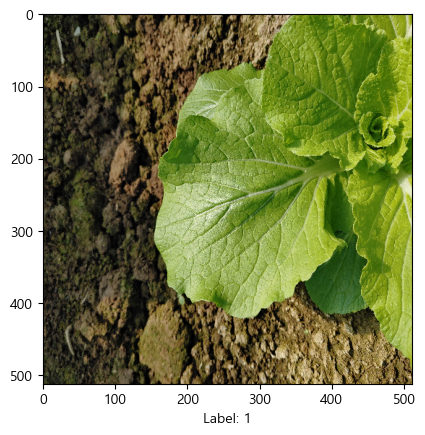

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# 이미지를 추출하여 시각화하는 함수
def visualize_image(generator):
    # 데이터 생성기에서 이미지를 추출
    image, label = generator.next()
    
    # 이미지를 시각화
    plt.imshow(image[0])
    print(image)
    plt.xlabel(f"Label: {np.argmax(label[0])}")
    plt.show()

# 데이터 생성기에서 이미지를 시각화
visualize_image(test_generator)